In [41]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os

In [2]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions


def rdf_from_gsd(gsd_file, atom_types='all', r_max=5, r_min=0.5, nbins=50, start=95):
    f = gsd.pygsd.GSDFile(open(gsd_file, "rb"))
    #trajectory = gsd.hoomd.open(gsd_file, 'rb')
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory[start:]:
        if atom_types == 'all':
            freud_rdf.compute(frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset=False)
    f.close()
    return freud_rdf

In [3]:
project = signac.get_project()
project

Project.get_project('/home/chris/cme/projects/ptb7-project')

In [4]:
state_dict = {"size":"small", "process":"quench"}

In [5]:
sweep_jobs = project.find_jobs(state_dict)

In [6]:
sweep_jobs

JobsCursor(project=Project.get_project('/home/chris/cme/projects/ptb7-project'), filter={'size': 'small', 'process': 'quench'}, doc_filter=None)

In [36]:
temps = []
for job in sweep_jobs:
    if job.sp['kT_reduced'] not in temps:
        temps.append(job.sp['kT_reduced'])
    else:
        pass
densities = []
for job in sweep_jobs:
    if job.sp['density'] not in densities:
        densities.append(job.sp['density'])
    else:
        pass

In [55]:
temp_colors = {}
temperatures = [2.3, 1.7, 2.0, 1.6, 1.4, 2.1, 1.9, 1.5, 2.2, 1.8, 2.4]
colors = ['#17202a','#797d7f','#3498db','#148f77',
          '#76448a','#784212','#9a7d0a','#e74c3c',
         '#f4d03f','#e67e22','#c39bd3']
#temperatures.sort()
#print(temperatures)
#for i, t in enumerate(temperatures):
#    temp_colors[t] = colors[i]

[1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]


In [82]:
density_colors = {}
densities = [1.0, 0.8, 0.9, 1.2, 1.1]
densities.sort()
for i, d in enumerate(densities):
    density_colors[d] = colors[i]


In [87]:
density_colors[0.95] = '#ff33d7'
print(density_colors)

{0.8: '#17202a', 0.9: '#797d7f', 1.0: '#3498db', 1.1: '#148f77', 1.2: '#76448a', 0.95: '#ff33d7'}


In [71]:
densities = [1.0, 0.8, 0.9, 0.95, 1.2, 1.1]
temperatures = [2.3, 1.7, 2.0, 1.6, 1.4, 2.1, 1.9, 1.5, 2.2, 1.8, 2.4]
labels = ['centers', 'all', 'sulfur', 'fluorine', 'oxygen']

In [48]:
(temperatures.sort)
print(temperatures)

[1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]


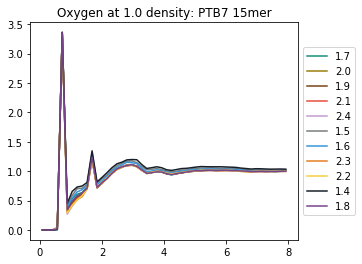

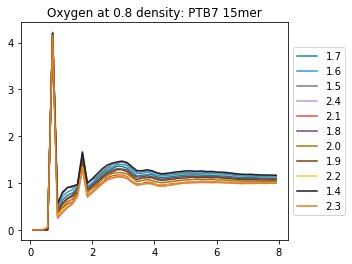

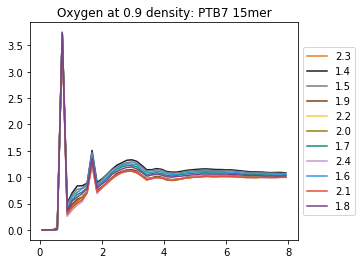

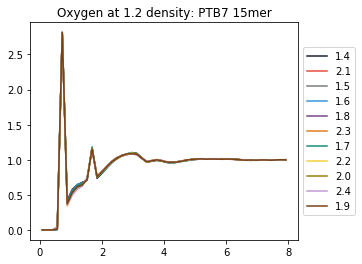

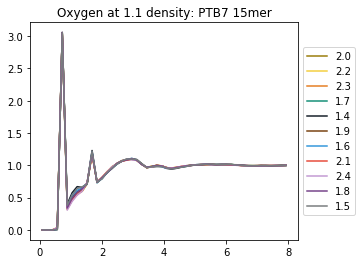

In [81]:
for den in densities:
    file_path = 'rdf-plots/density-{}'.format(den)
    try:
        os.mkdir(file_path)
    except:
        pass
    group_dict = {"size":"small", "process":"quench",
                  "density":den, "molecule":'PTB7_15mer_smiles'}
    group_jobs = project.find_jobs(group_dict)
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in group_jobs:
        data = np.genfromtxt(os.path.join(job.workspace(), 'rdf-data.txt'),
                             names=True, delimiter=",")
        color = temp_colors[job.sp['kT_reduced']]
        ax.plot(data['oxygen_x'], data['oxygen_y'], color=color, label=job.sp['kT_reduced'])
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Oxygen at {} density: PTB7 15mer'.format(den))
    filename = os.path.join(file_path, '15mer-{}-density-all-temps-oxygen.pdf'.format(den))
    plt.savefig(filename)
    
    

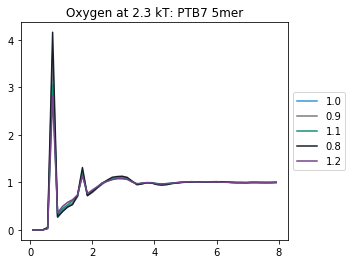

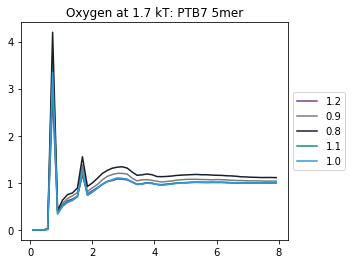

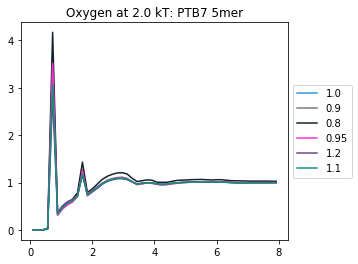

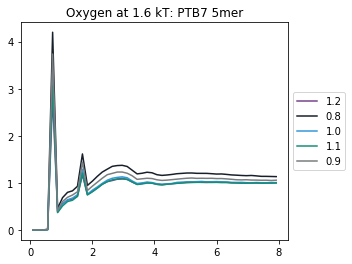

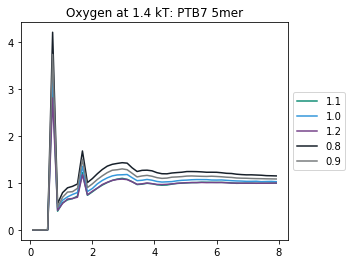

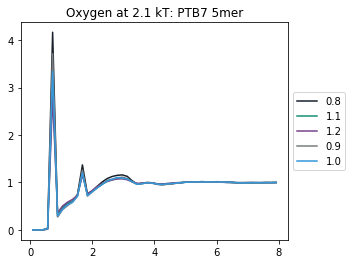

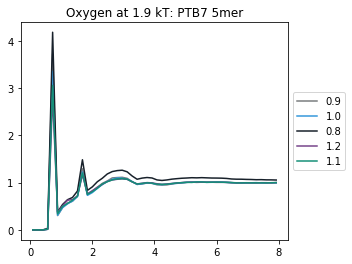

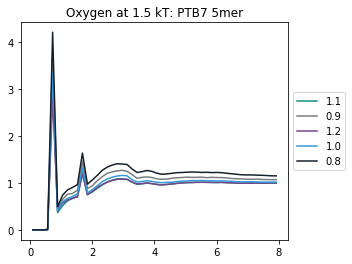

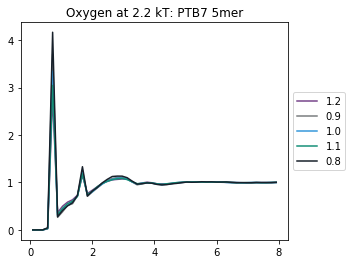

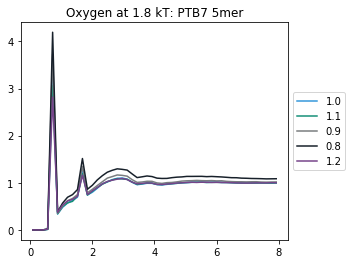

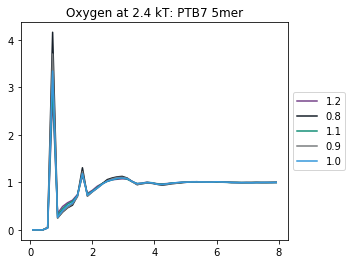

In [99]:
length = 5
rdf_type = 'oxygen'
title = 'Oxygen'

for temp in temperatures:
    file_path = 'rdf-plots/kT-{}'.format(temp)
    try:
        os.mkdir(file_path)
    except:
        pass
    group_dict = {"size":"small", "process":"quench",
                  "kT_reduced":temp, "molecule":'PTB7_{}mer_smiles'.format(length)}
    group_jobs = project.find_jobs(group_dict)
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in group_jobs:
        data = np.genfromtxt(os.path.join(job.workspace(), 'rdf-data.txt'),
                             names=True, delimiter=",")
        color = density_colors[job.sp['density']]
        ax.plot(data['{}_x'.format(rdf_type)],
                data['{}_y'.format(rdf_type)],
                color=color, label=job.sp['density'])
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('{} at {} kT: PTB7 {}mer'.format(title, temp, length))
    filename = os.path.join(file_path, '{}mer-{}kT-all-density-{}.pdf'.format(length, temp, title))
    plt.savefig(filename)

In [63]:
print(proj_schema)

{
 'beats_cut': 'int([-9881, -9681, -9661, ..., -4000, -3800], 35)',
 'density': 'float([0.8, 0.85, 0.9, ..., 1.15, 1.2], 9)',
 'dt': 'float([0.001], 1)',
 'e_factor': 'float([0.5], 1)',
 'kT_reduced': 'float([1.2, 1.3, 1.4, ..., 2.3, 2.4], 13)',
 'molecule': 'str([PTB7_10mer_smiles, PTB7_15mer_smiles, PTB7_5mer_smiles], 3)',
 'n_compounds': 'int([66, 100, 132, ..., 1000, 2000], 9)',
 'n_steps': 'float([10000000.0, 20000000.0, 23000000.0, ..., 60000000.0, 500000000.0], 26)',
 'original_id': 'str([001d1416fedf98dea731e30b7d928762, 00f48f6b7d2d1c502a270b3025a51e5c, 00f8468f8c1465d848bd27c55e48e493, ..., ff09feab17dedbb97fccb5f800ef1bdc, ffb19d6519b8334b0747dad0568ed9ea], 434)',
 'process': 'str([anneal, quench], 2)',
 'remove_hydrogens': 'bool([True], 1)',
 'save': 'str([false, true], 2)',
 'size': 'str([large, medium, small], 3)',
 'tau': 'int([1], 1)',
}


In [28]:
rdf_types = [['centers'], ['all'], ['ss'], ['f'], ['os']]
labels = ['centers', 'all', 'sulfur', 'fluorine', 'oxygen']

In [29]:
'''
job_pass = 0
job_fail = 0
failed_jobs = []
start = time.time()
for job in sweep_jobs:
    try:
        rdf_data = []
        column_labels = []
        #print(job.workspace())
        for typ, label in zip(rdf_types, labels):
            if typ[0] == 'centers':
                gsd_file = "{}/centers.gsd".format(job.workspace())
                atom_types = 'all'
                column_labels.append("{0}_x,{0}_y".format(label))
            else:
                gsd_file = "{}/trajectory.gsd".format(job.workspace())
                atom_types = typ[0]
                column_labels.append(",{0}_x,{0}_y".format(label))
                
            rdf_results = rdf_from_gsd(gsd_file,
                                        atom_types,
                                        r_min=0,
                                        r_max=8,
                                        start=92)    
            rdf_data.append(rdf_results.bin_centers)
            rdf_data.append(rdf_results.rdf)

        headers = '{}'*len(labels)
        text_file = "{}/rdf-data.txt".format(job.workspace())
        np.savetxt(text_file, np.transpose(rdf_data),
                   header=headers.format(*column_labels),
                   delimiter=",")
        
        text_file2 = "rdf-outputs/{}-rdf.txt".format(job.id)
        np.savetxt(text_file2, np.transpose(rdf_data),
                   header=headers.format(*column_labels),
                   delimiter=",")
        job_pass += 1
        print("{} Complete".format(job.id))

    except Exception as e:
        print(e)
        job_fail += 1
        print("{} FAILED".format(job.id))
        failed_jobs.append(job.workspace())
        continue

print('---------------')
finish = time.time()
print(finish - start)

36a213478233a2dc99c7d32986de1a27 Complete
50c629573e2e67bdba81a517dc8899dd Complete
ce0a993c0b7a295e2e39188f8b7c6608 Complete
dec75faed5e8274416d38fe7d0313a57 Complete
a391acf254ccab33d34cc72c9cbdea15 Complete
536dc36264f668b98d244e3dbf756cbb Complete
c3b41ded56fae483e82f594b15a8ce43 Complete
1ebf853f842e39f472dd6440857a4c8c Complete
3a3c0c3c3314f28475c7cb9541ba61dc Complete
11c430f279b6ffa3db5f7ca362405405 Complete
967ae38150f77f26fc3774a0076ea59e Complete
f010c77fd41912a6cb3ad4f0d6b8400b Complete
b1d816218a78fde6fe7797406326c253 Complete
e9f51a835f9133ff6c1b6953596abfdb Complete
b708b5ff868ed2dba7200146d77e90ba Complete
9cfcf0288a16af4969d0005a546aff8c Complete
7f491f4df80ee552b369d65fb66b135e Complete
b45af4ff0f9517823994bd70d23e9ade Complete
5d2ee701f636b6ceea7e3d3eac4d47e6 Complete
6a0df80c9f5e96ae39077b6b00666eec Complete
03a6a7d517c67da68f28a1e644149471 Complete
f53993e769f03f88ae907622563e820d Complete
5dce09fa01ddf4540d8ea508442c4911 Complete
9142b280d6297b31184de0676eedf51d C